# Lab 3: Stochastic Gradient Descent

The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

You have to send the filled notebook named **"L3_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 17, 2019. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

import tqdm

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [2]:
from sklearn import model_selection

diabetes_data = pd.read_csv("w8a.csv", sep=";")

diabetes_train, diabetes_test = model_selection.train_test_split(diabetes_data)
diabetes_train_x = diabetes_train.iloc[:, :-1].values
diabetes_train_y = diabetes_train.iloc[:, -1].values
diabetes_train_y[diabetes_train_y == 0] = -1

diabetes_test_x = diabetes_test.iloc[:, :-1].values
diabetes_test_y = diabetes_test.iloc[:, -1].values
diabetes_test_y[diabetes_test_y == 0] = -1

## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [3]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=2) 
model.fit(diabetes_train_x, diabetes_train_y)
y_pred = model.predict(diabetes_test_x)

and we compute the accuracy score to evaluate the model performance:

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(diabetes_test_y, y_pred)

0.9882608346064163

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

In [19]:
class StochasticLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, alpha):
        self.coef_  = None
        self.alpha_ = alpha
        self.lr_     = 1e-4
        self.bsize_  = None
        self.coef_history_ = []
        self.f_history_ = []
        self.test_history = []

        self.gamma =.9 # .999 # RMSprop and Adam hyperparam

        self.beta = .9 # adam momentum hyperparameter

    def logistic(self, z):
        return 1/(1+np.exp(-z))

    def loss(self, X, y, w, alpha):
        assert X.shape[0] == y.shape[0] and X.shape[1] == w.shape[0], 'mismatch in matrix dimensions !'
        F = 0.5*alpha*np.linalg.norm(w)**2
        for i in range(X.shape[0]):
            F += np.log(1+np.exp(-y[i]*np.dot(w, X[i])))/X.shape[0]
        return F

    def loss_dw(self, X, y, w, alpha):
        
        assert X.shape[0] == y.shape[0] and X.shape[1] == w.shape[0], 'mismatch in matrix dimensions !'
        dF = (alpha*w).astype(np.float32)
        for i in range(X.shape[0]):
            dF += -y[i]*(1 - self.logistic(y[i]*np.dot(w, X[i])))*X[i]/X.shape[0]
        return dF

    def step(self, loss_val, loss_history, patience = 20, factor = .1):
        """learning rate schedule, lowers the learning rate once in a plateau.

        Args:
            loss_val ([type]): [description]
            loss_history ([type]): [description]
        """
        if len(loss_history) < patience or len(loss_history)%patience != 0:
            return
        else:
            if loss_val > np.min(loss_history[-50:]):
                print(f' - epoch {len(loss_history)+1} | reducing learning rate from {self.lr_} to {self.lr_*factor}')
                self.lr_ = self.lr_*factor

        
    def fit(self, X, y, start, lr=1e-1, bsize=50, max_iter=500, optimizer = 'vanilla', eval_size = 100, f_eval = 5):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        f_eval: frequency of evaluation of data
        
        Note:
        -----
        Updates self.coef_
        """        
        
        self.lr_ = lr
        self.bsize = bsize

        # Normalize data first.
        # xm, xstd = np.mean(X, axis = 0), np.std(X, axis = 0)
        # X = (X - xm)/(xstd+1e-8)
        X = (X - np.min(X))/(np.max(X) - np.min(X) +1e-8)

        eval_ids = np.random.randint(0, X.shape[0], eval_size)
        X_test = X[eval_ids, ...]
        y_test = y[eval_ids]
    
        mask = [True if not _i in eval_ids else False for _i in range(X.shape[0]) ]
        X = X[mask, ...]
        y = y[mask]

        st = 1. if not optimizer == 'adam' else 0.
        mt = 0.
        np.random.seed(0)
        self.coef_ = np.random.rand(X.shape[1])
        self.history = []
        for i in tqdm.tqdm(range(1, max_iter)):
            for b in range(0, X.shape[0], bsize):
                Xsample = X[b:b+bsize, ...]
                ysample = y[b:b+bsize]
                F = self.loss(Xsample, ysample, self.coef_, self.alpha_)
                dF = self.loss_dw(Xsample, ysample, self.coef_, self.alpha_)
                if optimizer == 'vanilla':
                    self.coef_ = self.coef_ - self.lr_*dF
                elif optimizer == 'adagrad':
                    st = st+ dF**2
                    self.coef_ = self.coef_ - self.lr_*dF/(np.sqrt(st)+1e-8)
                elif optimizer == 'rmsprop':
                    st = self.gamma*st + (1 - self.gamma)*dF**2
                    self.coef_ = self.coef_ - self.lr_*dF/(np.sqrt(st) + 1e-8)
                elif optimizer == 'adam':
                    st_new = (self.gamma*st + (1 - self.gamma)*(dF/100)**2)/(1-self.gamma**i)
                    mt_new = (self.beta*mt + (1-self.beta)*(dF/100))/(1-self.beta**i)
                    st = st_new
                    mt = mt_new
                    self.coef_ = self.coef_ - self.lr_*mt/(np.sqrt(st)+1e-8)
            if i%f_eval == 0:
                # we can also set alpha to zero here if we are only interested in the fitting loss.
                F_test = self.loss(X_test, y_test, self.coef_, self.alpha_)
                self.test_history.append(F_test)
            self.step(F, self.history)

            self.history.append(F)

         
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        # xm, xstd = np.mean(X, axis = 0), np.std(X, axis = 0)
        X = (X - np.min(X))/(np.max(X) - np.min(X) +1e-8)
        preds = np.sign(np.dot(X, self.coef_))
        return preds

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        score = len(np.where(y_pred == y)[0])/len(y)
        return score


100%|██████████| 39/39 [00:49<00:00,  1.28s/it]


Text(0.5, 1.0, 'validation loss')

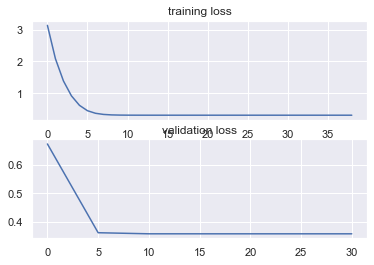

In [20]:
model = StochasticLogisticRegression(alpha = 0.1)
model.gamma = .5
model.beta = .5

n_epochs = 40
model.fit(diabetes_train_x, diabetes_train_y, 0, optimizer = 'adam', lr = 1e-4, max_iter =n_epochs)


fig, ax = plt.subplots(2)
ax[0].plot(model.history)
ax[0].set_title('training loss')

ax[1].plot([5*i for i in range(len(model.test_history))], model.test_history)
ax[1].set_title('validation loss')



Apply to the data

Let's do grid seach to find a good learning rate for each model.

100%|██████████| 19/19 [00:25<00:00,  1.32s/it]


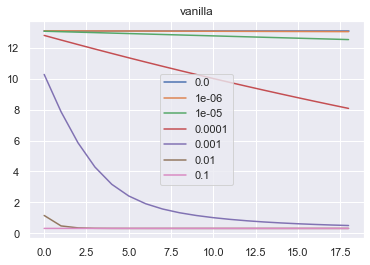

lr = 0.0 --> score = 0.0245
lr = 1e-06 --> score = 0.0245
lr = 1e-05 --> score = 0.0266
lr = 0.0001 --> score = 0.0417
lr = 0.001 --> score = 0.8665
lr = 0.01 --> score = 0.8911
lr = 0.1 --> score = 0.8902


100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


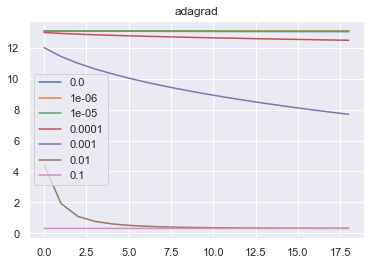

lr = 0.0 --> score = 0.0245
lr = 1e-06 --> score = 0.0245
lr = 1e-05 --> score = 0.0245
lr = 0.0001 --> score = 0.0266
lr = 0.001 --> score = 0.0377
lr = 0.01 --> score = 0.8909
lr = 0.1 --> score = 0.8908


100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


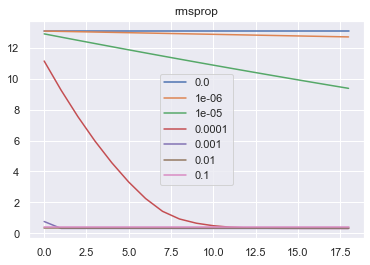

lr = 0.0 --> score = 0.0245
lr = 1e-06 --> score = 0.0245
lr = 1e-05 --> score = 0.0310
lr = 0.0001 --> score = 0.8905
lr = 0.001 --> score = 0.8898
lr = 0.01 --> score = 0.8898
lr = 0.1 --> score = 0.8825


100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


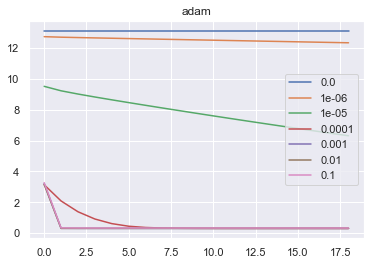

lr = 0.0 --> score = 0.0245
lr = 1e-06 --> score = 0.0273
lr = 1e-05 --> score = 0.0467
lr = 0.0001 --> score = 0.8898
lr = 0.001 --> score = 0.8893
lr = 0.01 --> score = 0.8894
lr = 0.1 --> score = 0.8820


In [21]:
lr_list = [0., 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
optimizers = ['vanilla', 'adagrad', 'rmsprop', 'adam']
for opt in optimizers:
    hists = []
    scores = []

    for lr in lr_list:
        model = StochasticLogisticRegression(alpha = 0.1)
        if opt == 'adam':
            model.gamma = .5
            model.beta = .5
        model.fit(diabetes_train_x, diabetes_train_y, 0, optimizer = opt, lr = lr, max_iter=20)
        hists.append(model.history)
        score = model.evaluate(diabetes_test_x, diabetes_test_y)
        scores.append(score)

    plt.figure()
    for x in hists:
        plt.plot(x)

    plt.legend(lr_list)
    plt.title(opt)
    plt.show()

    for lr, score in zip(lr_list, scores):
        print('lr = %s --> score = %.4f'%(lr, score))

In [22]:
model.evaluate(diabetes_test_x, diabetes_test_y)

0.8819651041247889

100%|██████████| 39/39 [01:07<00:00,  1.74s/it]


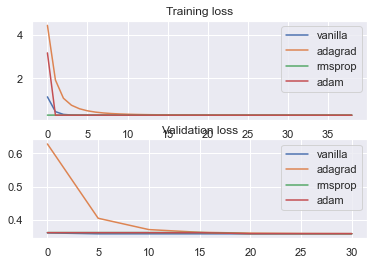

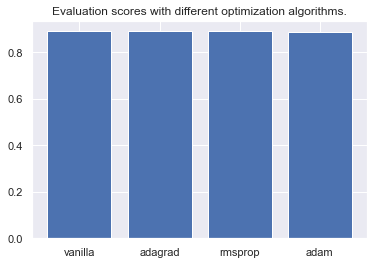

optimizer vanilla --> score 0.8905952668113961
optimizer adagrad --> score 0.8905684650639222
optimizer rmsprop --> score 0.8895231969124386
optimizer adam --> score 0.8892819811851733


In [26]:
optimizers = ['vanilla', 'adagrad', 'rmsprop', 'adam']

hists = []
test_hists = []
scores = []

for opt in optimizers:   
    model = StochasticLogisticRegression(alpha = 0.1)
    if opt == 'adam':
        model.gamma = .5
        model.beta = .5
    lr = 1e-2
    model.fit(diabetes_train_x, diabetes_train_y, 0, optimizer = opt, lr = lr, max_iter = 40)
    hists.append(model.history)
    test_hists.append(model.test_history)
    score = model.evaluate(diabetes_train_x, diabetes_train_y)
    scores.append(score)

# plt.figure()
# for x in hists:
#     plt.plot(x)

# plt.legend(optimizers)

fig, ax = plt.subplots(2)
for x in hists:
    ax[0].plot(x)
ax[0].legend(optimizers)
ax[0].set_title('Training loss')

for x in test_hists:
    ax[1].plot([5*i for i in range(len(x))], x)
ax[1].legend(optimizers)
ax[1].set_title('Validation loss')

plt.figure()
plt.bar(optimizers, scores)
plt.title('Evaluation scores with different optimization algorithms.')
plt.show()

for score, opt in zip(scores, optimizers):
    print(f'optimizer {opt} --> score {score}')

Text(0.5, 1.0, 'Validation loss')

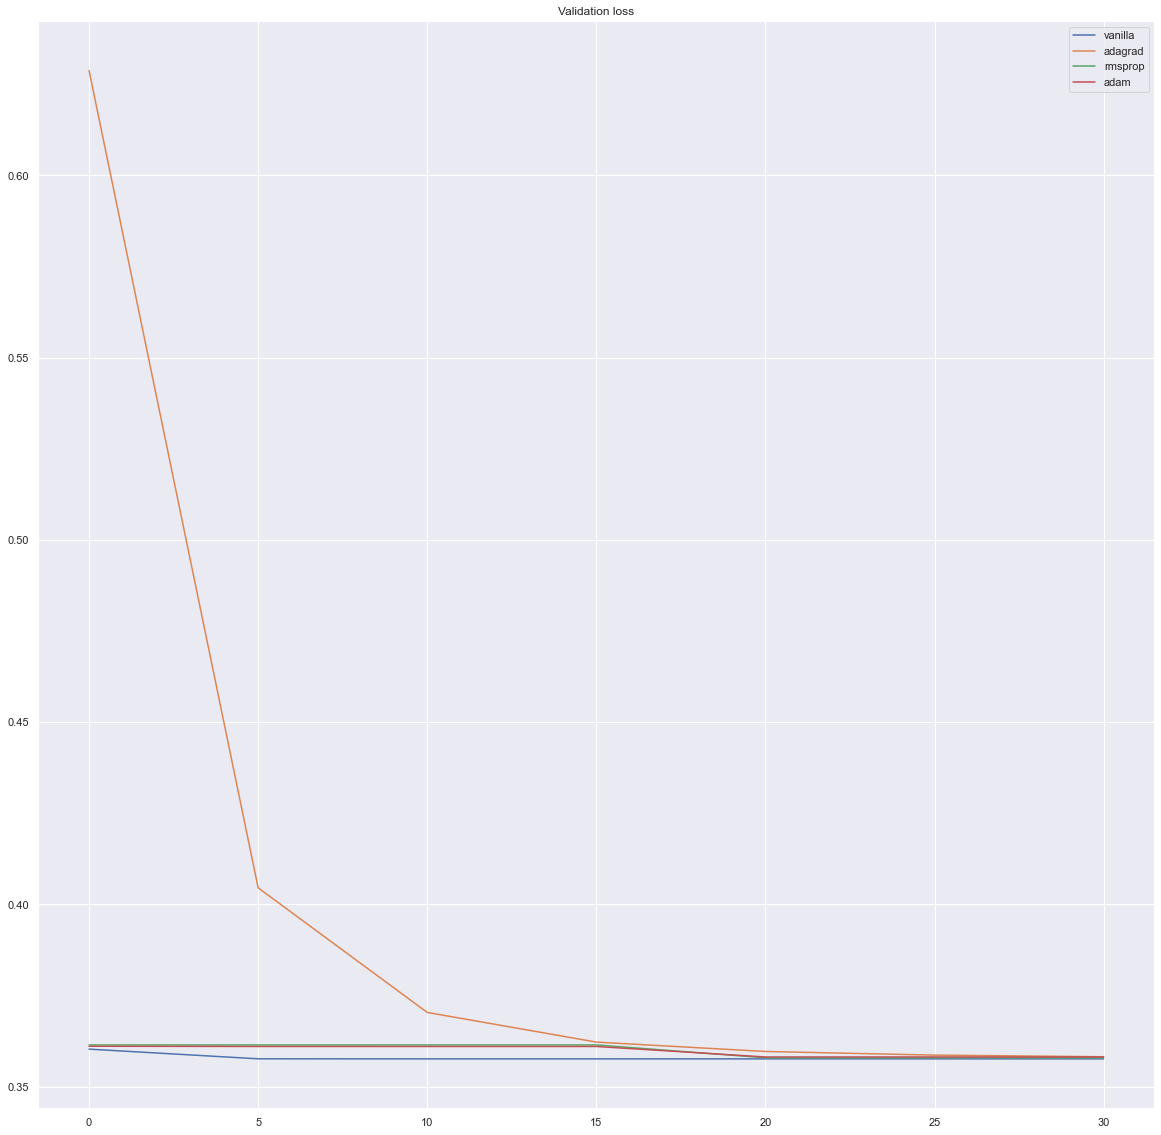

In [33]:
# Zoom in on validation loss history.
fig, ax = plt.subplots(1, 1, figsize = (20, 20))

for x in test_hists:
    ax.plot([5*i for i in range(len(x))], x)
ax.legend(optimizers)
ax.set_title('Validation loss')

Comment the results

From the results above we can see that using optimizers such as ADAM or RMSProp helps the model converge faster than vanilla SGD.

However SGD, has slightly better generalization as the validation loss is lower than for the other methods.

Implement only one acceleration method and compare the results